In [1]:
!git clone https://github.com/herm23/Project-NNDL.git

Cloning into 'Project-NNDL'...
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 7 (delta 0), reused 4 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (7/7), 472.39 KiB | 1.42 MiB/s, done.


In [2]:
%cd Project-NNDL/

/content/Project-NNDL


Link per il datset di CompCar (trovato su sito ufficiale): https://drive.google.com/drive/folders/18EunmjOJsbE5Lh9zA0cZ4wKV6Um46dkg


In [3]:
!pip install -U -q PyDrive

Import necessari

In [4]:
from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import os

Scarico i dati direttamente dal drive pubblico

In [5]:
#Autenticazione
auth.authenticate_user()

gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [6]:
# Estrazione dei dati dalla cartella
# ID della cartella pubblica
folder_id = '18EunmjOJsbE5Lh9zA0cZ4wKV6Um46dkg'

# Cartella locale per salvare i dati
save_path = '/content/Project-NNDL/compcar_dataset'
os.makedirs(save_path, exist_ok=True)

# Lista file nella cartella Drive
file_list = drive.ListFile({'q': f"'{folder_id}' in parents and trashed=false"}).GetList()

# Scarica tutti i file
for file in file_list:
    print(f"Scaricando {file['title']}")
    file.GetContentFile(os.path.join(save_path, file['title']))



Scaricando sv_data.zip
Scaricando sv_data.z03
Scaricando sv_data.z02
Scaricando sv_data.z01
Scaricando data.zip
Scaricando data.z22
Scaricando data.z21
Scaricando data.z20
Scaricando data.z19
Scaricando data.z18
Scaricando data.z17
Scaricando data.z16
Scaricando data.z15
Scaricando data.z14
Scaricando data.z13
Scaricando data.z12
Scaricando data.z11
Scaricando data.z10
Scaricando data.z09
Scaricando data.z08
Scaricando data.z07
Scaricando data.z06
Scaricando data.z05
Scaricando data.z04
Scaricando data.z03
Scaricando data.z02
Scaricando data.z01
Scaricando README.txt


In [7]:
!apt-get install -y p7zip-full


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-8).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [8]:
%cd /content/Project-NNDL/compcar_dataset

/content/Project-NNDL/compcar_dataset


password per unzippare: d89551fd190e38

In [9]:
!7z x data.zip -o./compcar_dataset/unzipped


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.00GHz (50653),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 391417395 bytes (374 MiB)

Extracting archive: data.zip
  1% 4096 Open               56% 188416 Open                --
Path = data.zip
Type = zip
Physical Size = 391417395
Embedded Stub Size = 4
64-bit = +
Total Physical Size = 16539487795
Multivolume = +
Volume Index = 22
Volumes = 23

  0%    
Enter password (will not be echoed):
  0% 5 - data/image/1/1101/2011/07b90decb92ba6.jpg                                                    0% 148 - data/image/1/1112/2013/5551a55b9fc425.jpg                   

Dataset (label = maker)

In [10]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import scipy.io as sio

class CarMakerDataset(Dataset):
    def __init__(self, image_root, mat_path, transform=None):
        """
        image_root: path a 'image/' (che contiene make_id/.../image.jpg)
        mat_path: path a 'make_model_name.mat'
        transform: trasformazioni PyTorch
        """
        self.image_root = image_root
        self.transform = transform
        self.samples = []
        self.class_to_idx = {}
        self.idx_to_class = {}

        # Carica la lista dei make_id -> make_name
        mat = sio.loadmat(mat_path)
        make_names = [name[0] for name in mat['make_names'][:, 0]]

        # Crea mapping: make_id (1-based) → make_name
        self.make_id_to_name = {i+1: make_names[i] for i in range(len(make_names))}

        # Crea mapping: make_name → label index
        for idx, name in enumerate(sorted(set(make_names))):
            self.class_to_idx[name] = idx
            self.idx_to_class[idx] = name

        # Costruisce lista di immagini e le etichette (maker)
        for make_id_str in sorted(os.listdir(image_root)):
            make_path = os.path.join(image_root, make_id_str)
            if not os.path.isdir(make_path):
                continue
            make_id = int(make_id_str)

            if make_id not in self.make_id_to_name:
                continue  # Skip se non è nel .mat

            maker_name = self.make_id_to_name[make_id]
            label = self.class_to_idx[maker_name]

            # Cerca ricorsivamente immagini
            for root, _, files in os.walk(make_path):
                for file in files:
                    if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                        img_path = os.path.join(root, file)
                        self.samples.append((img_path, label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label


# Contrastive Learning

In [11]:
from torchvision.transforms import transforms, ToTensor
import torchvision
import torch
import os
import pandas as pd
import h5py
import random
import numpy as np

seed = 0
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

NUM_WORKERS = os.cpu_count()

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)
print("Number of workers:", NUM_WORKERS)

# path
img = '/content/Project-NNDL/compcar_dataset/compcar_dataset/unzipped/data/image'
maker_path = '/content/Project-NNDL/compcar_dataset/compcar_dataset/unzipped/data/misc/make_model_name.mat'

Device: cuda:0
Number of workers: 2


In [12]:
class ContrastiveTransformations(object):

    def __init__(self, base_transforms, n_views=2):
        self.base_transforms = base_transforms
        self.n_views = n_views

    def __call__(self, x):
        return [self.base_transforms(x) for i in range(self.n_views)]

In [13]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # tutte le immagini diventano 224x224
    transforms.RandomHorizontalFlip(p=0.5), # Horizontal flip
    transforms.RandomResizedCrop(size=96),  # Random crop
    transforms.RandomApply([transforms.ColorJitter(0.5, 0.5, 0.5, 0.1)], p=0.8),  # Color distorsion
    transforms.RandomGrayscale(p=0.2), # Random grayscale
    transforms.GaussianBlur(kernel_size=9),  # Gaussian blur
    transforms.ToTensor(),
])

In [14]:
from torch.utils.data import random_split

# Carica l'intero dataset
full_dataset = CarMakerDataset(img, maker_path, transform=ContrastiveTransformations(transform, n_views=2))

# Imposta la proporzione di train/val
train_size = int(0.8 * len(full_dataset))  # 80% train
val_size = len(full_dataset) - train_size  # 20% validation

# Split random
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

Guardo qualche immagine

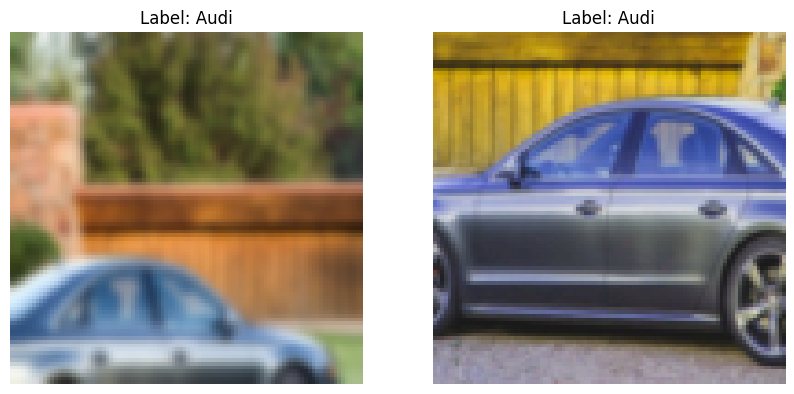

In [15]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
import numpy as np

img, label = train_dataset[0]
fig, axs = plt.subplots(1, len(img), figsize=(10, 5))
for i, im in enumerate(img):
    im_np = im.permute(1, 2, 0).numpy()
    axs[i].imshow(im_np)
    axs[i].set_title(f"Label: {train_dataset.dataset.idx_to_class[label]}")
    axs[i].axis('off')

plt.show()

torch.Size([12, 3, 96, 96])


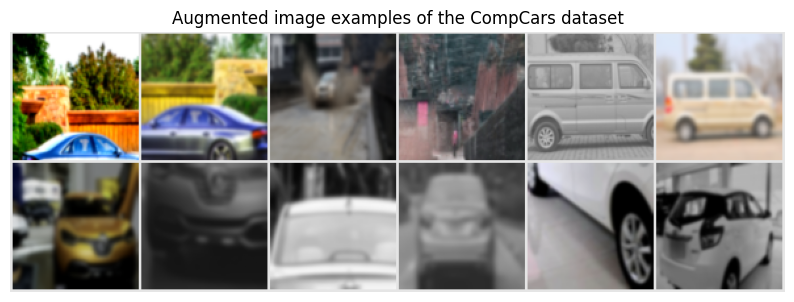

In [16]:
# Visualize some examples
NUM_IMAGES = 6
imgs = torch.stack([img for idx in range(NUM_IMAGES) for img in train_dataset[idx][0]], dim=0)
print(imgs.shape)


img_grid = torchvision.utils.make_grid(imgs, nrow=6, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)
plt.figure(figsize=(10,5))
plt.title('Augmented image examples of the CompCars dataset')
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

Rete contrastive formata da encoder=ResNet34 e trasformhead=2 linear layers

In [17]:
from torch.nn import Module, Sequential, Conv2d, BatchNorm2d, ReLU, MaxPool2d, AdaptiveAvgPool2d, Linear, Dropout

class MainPath(Module):

    def __init__(self, in_channels, filters, kernel_size, stride=1):
        super().__init__()
        F1, F2 = filters
        self.main_path = Sequential(
            Conv2d(in_channels, F1, kernel_size=1, stride=stride),
            BatchNorm2d(F1),
            ReLU(),
            Conv2d(F1, F2, kernel_size=kernel_size, padding=kernel_size//2),
            BatchNorm2d(F2),
        )
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, torch.nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()
        if isinstance(module, torch.nn.Conv2d):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()

    def forward(self, x):
        y = self.main_path(x)
        return y

class IdentityBlock(MainPath):

    def __init__(self, in_channels, filters, kernel_size):
        super().__init__(in_channels, filters, kernel_size)
        self.relu = ReLU()

    def forward(self, x):
        y = self.relu(self.main_path(x) + x)
        return y

class ConvolutionalBlock(MainPath):

    def __init__(self, in_channels, filters, kernel_size):
        super().__init__(in_channels, filters, kernel_size, stride=2)
        self.relu = ReLU()
        self.shortcut_path = Sequential(
            Conv2d(in_channels, filters[1], kernel_size=1, stride=2),
            BatchNorm2d(filters[1])
        )
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, torch.nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()
        if isinstance(module, torch.nn.Conv2d):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()

    def forward(self, x):
        y = self.relu(self.main_path(x) + self.shortcut_path(x))
        return y

class ResNet34(Module):

    def __init__(self):
        super().__init__()
        self.network = Sequential(
            Conv2d(3, 64, kernel_size=7, stride=2),
            BatchNorm2d(64),
            MaxPool2d(kernel_size=3, stride=2, padding=1),
            ConvolutionalBlock(64, [64, 64], kernel_size=3),
            Dropout(0.2),
            IdentityBlock(64, [64, 64], kernel_size=3),
            IdentityBlock(64, [64, 64], kernel_size=3),
            ConvolutionalBlock(64, [128, 128], kernel_size=3),
            Dropout(0.2),
            IdentityBlock(128, [128, 128], kernel_size=3),
            IdentityBlock(128, [128, 128], kernel_size=3),
            IdentityBlock(128, [128, 128], kernel_size=3),
            ConvolutionalBlock(128, [256, 256], kernel_size=3),
            Dropout(0.2),
            IdentityBlock(256, [256, 256], kernel_size=3),
            IdentityBlock(256, [256, 256], kernel_size=3),
            IdentityBlock(256, [256, 256], kernel_size=3),
            IdentityBlock(256, [256, 256], kernel_size=3),
            IdentityBlock(256, [256, 256], kernel_size=3),
            ConvolutionalBlock(256, [512, 512], kernel_size=3),
            Dropout(0.2),
            IdentityBlock(512, [512, 512], kernel_size=3),
            IdentityBlock(512, [512, 512], kernel_size=3),
            AdaptiveAvgPool2d((1, 1))
        )
        self.apply(self._init_weights)

    def forward(self, x):
        y = self.network(x).reshape((x.shape[0], -1))
        return y

    def _init_weights(self, module):
        if isinstance(module, torch.nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()
        if isinstance(module, torch.nn.Conv2d):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()

class SimCLR(Module):
    def __init__(self):
        super().__init__()
        self.convnet = ResNet34()
        self.projection_head = Sequential(
            Linear(512, 256),
            ReLU(),
            Linear(256, 128)
        )

    def forward(self, x):
        features = self.convnet(x)
        out = self.projection_head(features)
        return out


Loss function = Xent

In [18]:
import torch.nn.functional as F

def NT_Xent_loss(features_batch, temperature, mode='train'):
    """
    Takes in input a features_batch tensor of shape (BatchSize * 2, feature_dim), the temperature parameter,
    and computes the NT_Xent_loss
    """
    # Cosine similarity between all pairs
    features = F.normalize(features_batch, dim=1)
    cos_sim = features @ features.T

    # Mask out cosine similarity to itself
    self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
    cos_sim.masked_fill_(self_mask, -9e15)

    # Find the positive example, we know that it is batch_size//2 away from the original example
    pos_mask = self_mask.roll(shifts=cos_sim.shape[0]//2, dims=0)

    # NT_Xent loss
    cos_sim = cos_sim / temperature

    nll = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
    nll = nll.mean()

    # Get ranking position of positive example
    comb_sim = torch.cat([cos_sim[pos_mask][:,None],  # First position positive example
                            cos_sim.masked_fill(pos_mask, -9e15)],
                            dim=-1)
    sim_argsort = comb_sim.argsort(dim=-1, descending=True).argmin(dim=-1)

    acc_top1 = (sim_argsort == 0).float().mean()
    acc_top5 = (sim_argsort < 5).float().mean()

    return nll, acc_top1, acc_top5

Train loop

In [19]:
def train(model, device, train_loader, optimizer, lr_scheduler, epoch, loss_temperature, maxit=float('inf')):
    train_losses = []
    train_top5_accs = []

    model.train()
    model.to(device)
    for i, batch in enumerate(train_loader):
        imgs, _ = batch

        # Concatenate the two images along the batch dimension, so we get a tensor of shape (BatchDim * 2, 3, 96, 96)
        # Also remember to put the images on the GPU
        imgs = [img.to(device) for img in imgs]
        cat_imgs = torch.cat(imgs, dim=0)

        # Compute the features
        features = model(cat_imgs)

        # Compute the loss together with the accuracy metrics, and store them in the lists above
        nce_loss, acc_top1, acc_top5 = NT_Xent_loss(features, loss_temperature)
        train_losses.append(nce_loss.item())
        train_top5_accs.append(acc_top5.item())

        # Backpropagate the loss and perform the optimization step
        optimizer.zero_grad()
        nce_loss.backward()
        optimizer.step()

        print(f"Train Epoch: {epoch}, Iteration: {i}/{len(train_loader)},  \tLoss: {nce_loss.item():.6f}, \tTop1_Acc: {acc_top1.item():.6f}, \tTop5_Acc: {acc_top5.item():.6f}")

        if i >= maxit:
            return np.mean(train_losses), np.mean(train_top5_accs)
            break

    lr_scheduler.step()
    return np.mean(train_losses), np.mean(train_top5_accs)

@torch.no_grad()
def valid(model, device, val_loader, epoch, loss_temperature, maxit=float('inf')):
    model.eval()
    val_losses = []
    val_top5_accs = []
    for i, batch in enumerate(val_loader):
        imgs, _ = batch

        # Concatenate the images
        imgs = [img.to(device) for img in imgs]
        imgs = torch.cat(imgs, dim=0)

        # Compute the features
        features =  model(imgs)

        # Compute loss and accuracies, and store them
        nce_loss, acc_top1, acc_top5 = NT_Xent_loss(features, loss_temperature)
        val_losses.append(nce_loss.item())
        val_top5_accs.append(acc_top5.item())

        print(f"Valid Epoch: {epoch}, Iteration: {i}/{len(val_loader)},  \tLoss: {nce_loss.item():.6f}, \tTop1_Acc: {acc_top1.item():.6f}, \tTop5_Acc: {acc_top5.item():.6f}")
        if i >= maxit:
          return np.mean(val_losses), np.mean(val_top5_accs)
          break

    return np.mean(val_losses), np.mean(val_top5_accs)

In [ ]:
import torch.optim as optim
import os
from google.colab import drive
drive.mount('/content/drive')

# Define training hyperparameters
temperature=0.07
weight_decay=1e-4
batch_size = 256
max_epochs=500
lr=2e-4

epochs = 1000
maxit = float('inf')

train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True, drop_last=True, pin_memory=True, num_workers=NUM_WORKERS)
val_dataloader = DataLoader(val_dataset, batch_size, shuffle=True, drop_last=True, pin_memory=True, num_workers=NUM_WORKERS)

# Define SimCLR Model
simclr_model = SimCLR()
simclr_model.to(device)

# Define Optimizer and Learning rate Scheduler
optimizer = optim.AdamW(simclr_model.parameters(), lr=lr, weight_decay=weight_decay)
lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = max_epochs, eta_min=lr/50)

# Riprendo dal checkpoint
checkpoint_path = "/content/drive/MyDrive/NNDL/progetto/contrastiveNN/best_checkpoint.pth"
checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
simclr_model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
lr_scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
start_epoch = checkpoint.get('epoch', 0) + 1

# Training Loop
train_losses = []
val_losses = []
train_top5_accs = []
val_top5_accs = []

patience = 3
counter = 0
best_val_loss = float('inf')
checkpoint_dir = "/content/drive/MyDrive/NNDL/progetto/contrastiveNN"

for epoch in range(start_epoch, epochs):
    # Training iterations and update lists
    train_loss, train_top5_acc = train(simclr_model, device, train_dataloader,
                                       optimizer, lr_scheduler, epoch,
                                       loss_temperature=temperature, maxit=maxit)
    train_losses.append(train_loss)
    train_top5_accs.append(train_top5_acc)
    print()

    # Validation iterations
    val_loss, val_top5_acc = valid(simclr_model, device, val_dataloader,
                                    epoch, loss_temperature=temperature, maxit=maxit)
    val_losses.append(val_loss)
    val_top5_accs.append(val_top5_acc)
    print()

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0  # reset counter

        # Salva il checkpoint completo
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': simclr_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': lr_scheduler.state_dict(),
            'val_loss': val_loss
        }
        torch.save(checkpoint, os.path.join(checkpoint_dir, "best_checkpoint.pth"))
        print(f"Checkpoint salvato all'epoca {epoch} con val_loss {val_loss:.4f}")

    else:
        counter += 1
        print(f"No improvement in val_loss for {counter} epochs.")

        if counter >= patience:
            print("Early stopping triggered.")
            break

Mounted at /content/drive
Train Epoch: 1, Iteration: 0/427,  	Loss: 5.047992, 	Top1_Acc: 0.078125, 	Top5_Acc: 0.205078
Train Epoch: 1, Iteration: 1/427,  	Loss: 4.851934, 	Top1_Acc: 0.097656, 	Top5_Acc: 0.224609
Train Epoch: 1, Iteration: 2/427,  	Loss: 5.018937, 	Top1_Acc: 0.083984, 	Top5_Acc: 0.242188
Train Epoch: 1, Iteration: 3/427,  	Loss: 4.853438, 	Top1_Acc: 0.113281, 	Top5_Acc: 0.253906
Train Epoch: 1, Iteration: 4/427,  	Loss: 4.689540, 	Top1_Acc: 0.134766, 	Top5_Acc: 0.296875
Train Epoch: 1, Iteration: 5/427,  	Loss: 5.083850, 	Top1_Acc: 0.111328, 	Top5_Acc: 0.250000
Train Epoch: 1, Iteration: 6/427,  	Loss: 4.960885, 	Top1_Acc: 0.091797, 	Top5_Acc: 0.242188
Train Epoch: 1, Iteration: 7/427,  	Loss: 4.923269, 	Top1_Acc: 0.130859, 	Top5_Acc: 0.285156
Train Epoch: 1, Iteration: 8/427,  	Loss: 4.918005, 	Top1_Acc: 0.107422, 	Top5_Acc: 0.255859
Train Epoch: 1, Iteration: 9/427,  	Loss: 4.834285, 	Top1_Acc: 0.117188, 	Top5_Acc: 0.271484
Train Epoch: 1, Iteration: 10/427,  	Loss: 5

In [ ]:
# Let's plot the training and validation losses and Top-5 Accuracy
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(train_losses, label='Train Loss')
ax[0].plot(val_losses, label='Valid Loss')

ax[1].plot(train_top5_accs, label='Train Top-5 Accuracy')
ax[1].plot(val_top5_accs, label='Valid Top-5 Accuracy')

ax[0].set_title('Loss')
ax[1].set_title('Top-5 Accuracy')

for i in range(2):
    ax[i].legend()
    ax[i].grid()

plt.show()

# Rete Classifier (su feaure di rete contrastive)

In [ ]:
from torch.nn import Module, Sequential, Conv2d, BatchNorm2d, ReLU, MaxPool2d, AdaptiveAvgPool2d, Linear, Dropout

class Classifier(Module):

    def __init__(self, feature_dim, num_classes):
        super().__init__()

        # Mapping from representation h to classes with a linear layer
        self.model = Linear(feature_dim, num_classes)

    def forward(self, x):
        return self.model(x)

Creo gli ingressi con le feature della contrastive NN

In [ ]:
from torch.utils.data import random_split

img_transforms = transforms.Compose([transforms.Resize((224, 224)),
                                     transforms.ToTensor()])

# Carica l'intero dataset
full_dataset = CarMakerDataset(img, maker_path, transform=img_transforms)

# Percentuali
total_size = len(full_dataset)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size  # Per compensare l'approssimazione

# Split random
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# Stampa
print(f"Train size: {len(train_dataset)}")
print(f"Val size:   {len(val_dataset)}")
print(f"Test size:  {len(test_dataset)}")

In [ ]:
from copy import deepcopy
import torch.nn as nn
from torch.utils import data
from tqdm import tqdm

@torch.no_grad()
def prepare_data_features(model, dataset, device, batch_size=64, num_workers=4):
    # Copia solo la rete backbone senza la projection head
    network = deepcopy(model.convnet)
    network.eval()
    network.to(device)

    data_loader = data.DataLoader(dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False, drop_last=False)

    feats, labels = [], []
    for batch_imgs, batch_labels in tqdm(data_loader):
        batch_imgs = batch_imgs.to(device)
        batch_feats = network(batch_imgs)  # Passa solo convnet
        feats.append(batch_feats.cpu())
        labels.append(batch_labels)

    feats = torch.cat(feats, dim=0)
    labels = torch.cat(labels, dim=0)

    # Ordina per label (opzionale)
    labels, idxs = labels.sort()
    feats = feats[idxs]

    return data.TensorDataset(feats, labels)


# Define SimCLR Model
simclr_model = SimCLR()

train_feats_simclr = prepare_data_features(simclr_model, train_dataset)
val_feats_simclr = prepare_data_features(simclr_model, val_dataset)
test_feats_simclr = prepare_data_features(simclr_model, test_dataset)

train

In [ ]:
import torch.nn as nn
import numpy as np

def train(model, device, train_loader, optimizer, lr_scheduler, epoch, maxit=float('inf')):
    train_losses = []
    accs = []

    model.train()
    model.to(device)
    for i, batch in enumerate(train_loader):
        feats, labels = batch
        feats = feats.to(device)
        labels = labels.to(device)

        # Forward pass
        preds = model(feats)

        # Compute the cross entropy loss
        criterion = nn.CrossEntropyLoss()
        loss = criterion(preds, labels)
        acc = (preds.argmax(dim=-1) == labels).float().mean()

        train_losses.append(loss.item())
        accs.append(acc.item())

        # Backpropagate the loss and perform the optimization step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print(f"Train Epoch: {epoch}, Iteration: {i}/{len(train_loader)},  \tLoss: {loss.item():.6f}, \tAcc: {acc.item():.6f}")

        if i >= maxit:
            return np.mean(train_losses), np.mean(accs)
            break

    lr_scheduler.step()
    return np.mean(train_losses), np.mean(accs)

@torch.no_grad()
def valid(model, device, val_loader, epoch, maxit=float('inf')):
    model.eval()
    val_losses = []
    val_accs = []
    for i, batch in enumerate(val_loader):
        feats, labels = batch
        feats = feats.to(device)
        labels = labels.to(device)

        # Compute the features
        preds =  model(feats)

        # Compute loss and accuracies, and store them
        criterion = nn.CrossEntropyLoss()
        loss = criterion(preds, labels)
        acc = (preds.argmax(dim=-1) == labels).float().mean()

        val_losses.append(loss.item())
        val_accs.append(acc.item())

        print(f"Valid Epoch: {epoch}, Iteration: {i}/{len(val_loader)},  \tLoss: {loss.item():.6f}, \tAcc: {acc.item():.6f}")
        if i >= maxit:
          return np.mean(val_losses), np.mean(val_accs)
          break

    return np.mean(val_losses), np.mean(val_accs)

In [ ]:
import torch.optim as optim
import os
from google.colab import drive
drive.mount('/content/drive')

# Define training hyperparameters
weight_decay=1e-4
batch_size = 256
max_epochs=500
lr=2e-4

epochs = 1000
maxit = float('inf')

# Data loaders
train_dataloader = data.DataLoader(train_feats_simclr, batch_size=batch_size, shuffle=True,
                                drop_last=False, pin_memory=True, num_workers=0)
val_dataloader = data.DataLoader(val_feats_simclr, batch_size=batch_size, shuffle=False,
                              drop_last=False, pin_memory=True, num_workers=0)

# Define the simple classifier model
Class_model = Classifier(train_feats_simclr.tensors[0].shape[1], num_classes=163)
Class_model.to(device)

# Define Optimizer and Learning rate Scheduler
optimizer = optim.AdamW(Class_model.parameters(), lr=lr, weight_decay=weight_decay)
lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = max_epochs, eta_min=lr/50)

# Training Loop
train_losses = []
val_losses = []
train_accs = []
val_accs = []

patience = 3
counter = 0
best_val_loss = float('inf')
checkpoint_dir = "/content/drive/MyDrive/NNDL/progetto/classifierNN"

for epoch in range(epochs):
    # Training iterations and update lists
    train_loss, train_acc = train(Class_model, device, train_dataloader,
                                  optimizer, lr_scheduler, epoch, maxit=maxit)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    print()

    # Validation iterations
    val_loss, val_acc = valid(Class_model, device, val_dataloader,
                              epoch, maxit=maxit)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    print()

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0  # reset counter

        # Salva il checkpoint completo
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': Class_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': lr_scheduler.state_dict(),
            'val_loss': val_loss
        }
        torch.save(checkpoint, os.path.join(checkpoint_dir, "best_checkpoint.pth"))
        print(f"Checkpoint salvato all'epoca {epoch} con val_loss {val_loss:.4f}")

    else:
        counter += 1
        print(f"No improvement in val_loss for {counter} epochs.")

        if counter >= patience:
            print("Early stopping triggered.")
            break

Results

In [ ]:
# Let's plot the training and validation losses and Top-5 Accuracy
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(train_losses, label='Train Loss')
ax[0].plot(val_losses, label='Valid Loss')

ax[1].plot(train_accs, label='Train Top-5 Accuracy')
ax[1].plot(val_accs, label='Valid Top-5 Accuracy')

ax[0].set_title('Loss')
ax[1].set_title('Top-5 Accuracy')

for i in range(2):
    ax[i].legend()
    ax[i].grid()

plt.show()

test

In [ ]:
test_loader = torch.utils.data.DataLoader(
    test_feats_simclr,
    batch_size=256,
    shuffle=False,
    drop_last=False,
    pin_memory=True,
    num_workers=0
)

@torch.no_grad()
def test(model, device, test_loader):
    model.eval()
    test_accs = []
    test_losses = []
    criterion = nn.CrossEntropyLoss()

    for feats, labels in test_loader:
        feats = feats.to(device)
        labels = labels.to(device)

        preds = model(feats)
        loss = criterion(preds, labels)
        acc = (preds.argmax(dim=1) == labels).float().mean()

        test_losses.append(loss.item())
        test_accs.append(acc.item())

    mean_loss = np.mean(test_losses)
    mean_acc = np.mean(test_accs)

    print(f"\nTest Loss: {mean_loss:.4f}, Test Accuracy: {mean_acc:.4f}")
    return mean_loss, mean_acc

test_loss, test_acc = test(Class_model, device, test_loader)

# Rete finale

In [ ]:
import torch.nn as nn

class FullModel(nn.Module):
    def __init__(self, simclr_model, classifier):
        super().__init__()
        self.backbone = simclr_model.convnet  # solo backbone, senza projection head
        self.classifier = classifier           # classifier

    def forward(self, x):
        features = self.backbone(x)            # estrai feature da immagine
        output = self.classifier(features)     # classifica
        return output

Continual learning
---

